# Library

In [1]:
from __future__ import print_function

import tensorflow as tf
#config = tf.ConfigProto()
#config.gpu_options.allow_growth = True
#session = tf.Session(config=config)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf
"""
# Set CPU as available physical device
my_devices = tf.config.experimental.list_physical_devices(device_type='CPU')
tf.config.experimental.set_visible_devices(devices= my_devices, device_type='CPU')

# To find out which devices your operations and tensors are assigned to
tf.debugging.set_log_device_placement(True)

"""

tf.config.experimental.set_visible_devices([], 'GPU')
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)



import tensorflow.keras as keras
from keras.datasets import mnist
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, Dropout, Flatten,TimeDistributed
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.keras import backend as K
from tensorflow.keras import layers,models
import h5py
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import heapq
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import random
import h5py
import os
import matplotlib.pyplot as plt


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1536487980877712128
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 4905802171687331076
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 6573053863630176278
physical_device_desc: "device: XLA_GPU device"
]


Using TensorFlow backend.


## 1.Load and display data from h5 file






### download data from google drive

## 1A) Train on MNIST Fashion

In [28]:

class ScaleLayer(Layer):

    def __init__(self,scale, **kwargs):

        self.scale=scale;
        
        super(ScaleLayer, self).__init__(**kwargs)


    def build(self, input_shape):
        super(ScaleLayer, self).build(input_shape)

       
    def call(self, inputs):

        output=tf.image.resize(inputs,[self.scale,self.scale],method=tf.image.ResizeMethod.BICUBIC);
        output = tf.keras.backend.concatenate((output, output,output),axis=-1) ;


        #print(output.shape)

        return output

       

    def compute_output_shape(self, input_shape):
        return (input_shape[0],self.scale,self.scale,3)



def vgg16_head(img_input):

    pooling = 'No'

    include_top = False;



    x = TimeDistributed(ScaleLayer(224))(img_input)

    x = TimeDistributed(layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv1'))(x)
    x = TimeDistributed(layers.Conv2D(64, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block1_conv2'))(x)
    x = TimeDistributed(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))(x)

    # Block 2
    x = TimeDistributed(layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv1'))(x)
    x = TimeDistributed(layers.Conv2D(128, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block2_conv2'))(x)
    x = TimeDistributed(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))(x)

    # Block 3
    x = TimeDistributed(layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv1'))(x)
    x = TimeDistributed(layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv2'))(x)
    x = TimeDistributed(layers.Conv2D(256, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block3_conv3'))(x)
    x = TimeDistributed(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))(x)

    # Block 4
    x = TimeDistributed(layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv1'))(x)
    x = TimeDistributed(layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv2'))(x)
    x = TimeDistributed(layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block4_conv3'))(x)
    x = TimeDistributed(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))(x)

    # Block 5
    x = TimeDistributed(layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv1'))(x)
    x = TimeDistributed(layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv2'))(x)
    x = TimeDistributed(layers.Conv2D(512, (3, 3),
                      activation='relu',
                      padding='same',
                      name='block5_conv3'))(x)
    x = TimeDistributed(layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))(x)

    if include_top:
        # Classification block
        x = layers.Flatten(name='flatten')(x)
        x = layers.Dense(4096, activation='relu', name='fc1')(x)
        x = layers.Dense(4096, activation='relu', name='fc2')(x)
        x = layers.Dense(classes, activation='softmax', name='predictions')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)
        elif pooling =='No':
            x = x;
    return x

In [29]:

class AttentionLayer(Layer):

    def __init__(self, **kwargs):

        
        super(AttentionLayer, self).__init__(**kwargs)


    def build(self, input_shape):
        super(AttentionLayer, self).build(input_shape)


        self.input_shape_r = input_shape;
        #print('self.input_shape_r')
        #print(self.input_shape_r)

        L_size = 256;

        self.w = self.add_weight(name='w', 
                              shape=[L_size,1],
                              initializer='uniform',
                              trainable=True)
        self.V = self.add_weight(name='V', 
                      shape=[input_shape[2],L_size],
                      initializer='uniform',
                      trainable=True)

        self.U = self.add_weight(name='U', 
                      shape=[input_shape[2],L_size],
                      initializer='uniform',
                      trainable=True)

        

        self.bias_w = self.add_weight(shape=[1,1],
                              initializer='uniform',
                              name='bias_w')
        self.bias_V = self.add_weight(shape=[1,L_size],
                                      initializer='uniform',
                                      name='bias_V')
        self.bias_U = self.add_weight(shape=[1,L_size],
                                      initializer='uniform',
                                      name='bias_U')
        

  
       
    def call(self, inputs):


        inputs_r = K.expand_dims(inputs,axis=-2)


        #print('inputs')
        #print(inputs_r.shape)


        dot_products_V = K.dot(inputs_r,self.V)
        dot_products_U = K.dot(inputs_r,self.U)

        dot_products_V += self.bias_V;
        dot_products_U += self.bias_U;


        #print('dot product')
        #print(dot_products_V.shape)

        tanh_V = K.tanh(dot_products_V);
        sigmoid_U = K.sigmoid(dot_products_U);

        #print('tanh')
        #print(tanh_V.shape)

        comb_UV = tanh_V*sigmoid_U;

        #print('combUV')
        #print(comb_UV.shape)

        attention_weights = K.dot(comb_UV,self.w);

        attention_weights +=self.bias_w;

        attention_weights = K.exp(attention_weights);


        #print('attention_weights')
        #print(attention_weights.shape)


        attention_weights /= K.cast(K.sum(attention_weights,
                                  axis=1,
                                  keepdims=True) + K.epsilon(),
                            K.floatx());
        #print('attention_weights sum')
        #print(attention_weights.shape)

        #attention_weights = K.expand_dims(attention_weights);
        attention_weights= K.squeeze(attention_weights,axis = -1);
        #print('attention_weights last')
        #print(attention_weights.shape)

        weighted_output = inputs * attention_weights;

        self.Save =  attention_weights;


        output = K.sum(weighted_output, axis=1)

        #print('output')
        #print(output.shape)

        return output


       

    def compute_output_shape(self, input_shape):
        return (input_shape[0],input_shape[2])
    
    
class FCHeadNet:
  @staticmethod
  def build(baseModel, classes, D):
    # initialize the head model that will be placed on top of
    # the base, then add a FC layer
    headModel = baseModel.output
    headModel = TimeDistributed(layers.Flatten(name='flatten'))(headModel)
    headModel = TimeDistributed(layers.Dense(D, activation='relu', name='fc1'))(headModel)
    headModel = TimeDistributed(layers.Dense(D, activation='relu', name='fc2'))(headModel)
    headModel = AttentionLayer(name='attentionlayer')(headModel)
    headModel = tf.keras.layers.Dense(classes, activation='softmax', name='predictions')(headModel)
    # add a softmax layer
    #headModel = layers.Dense(classes, activation="softmax")(headModel)
    #headModel = layers.Dense(classes, activation='softmax', name='predictions2')(headModel)

    # return the model
    return headModel


In [4]:
import random
batch_size = 1
num_classes = 3


# input image dimensions
img_rows, img_cols = 128, 128

# the data, split between train and test sets

#(x_train, y_train), (x_test, y_test) = mnist.load_data()


p='/home/peppermint/Data_Sci/Attention_ML/1160_many_2.h5';

db=h5py.File(p);


X_stk, y_stk = db['images'],db['labels'];

X =np.zeros((116,10,128,128,3))
y = np.zeros((116,))

for ij in range(116):
    X[ij,...] = X_stk[ij*10:(ij+1)*10,...]
    y[ij,...] = y_stk[(ij*10+(ij+1)*10)//2]

print(X.shape)
print(y.shape)


total_size = X.shape[0];
index_random = np.arange(total_size)
i = int(X.shape[0] * 3/4)

random.shuffle(index_random)

train_index = list(index_random[:i]) ;
test_index = list(index_random[i:]) ;
train_index.sort()
test_index.sort()


x_train, x_test, y_train, y_test = X[train_index],X[test_index],y[train_index],y[test_index];

print(x_train.shape)

print(index_random)

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train_gray_zero = x_train[...,0]
x_train_gray_first = x_train[...,1]
x_train_gray_second = x_train[...,2]

x_train_gray_zero = x_train_gray_zero[...,None]
x_train_gray_first = x_train_gray_first[...,None]
x_train_gray_second = x_train_gray_second[...,None]


x_test_gray_zero = x_test[...,0]
x_test_gray_first = x_test[...,1]
x_test_gray_second = x_test[...,2]


x_test_gray_zero = x_test_gray_zero[...,None]
x_test_gray_first = x_test_gray_first[...,None]
x_test_gray_second = x_test_gray_second[...,None]

(116, 10, 128, 128, 3)
(116,)
(87, 10, 128, 128, 3)
[ 34  76  61  10  89  46  50  57  21  30   7  93  91  62  73  49  96  80
  33  72  92  35  81  18 114  84  17  94 111  86 110 108  65  90  79  19
  95  83  23  22  47  15 107  11  98  55 115  70  52  59  48  13 104  42
  28 112  75   0  74  14  31  39 100  43 103  32  63  29  66   1  54  12
  56  38  24   6   9   4 109  78  64  82  88  60  26  85  40  77  45 106
  41  67 102  27 105   5  58  16  69  97  99  25  53   2  87  37 101  68
   3  71  36  44  20   8 113  51]


In [24]:
x_train = tf.cast(x_train_gray_zero, tf.float32)
y_train = tf.cast(y_train, tf.float32)

x_test = tf.cast(x_test_gray_zero, tf.float32)
y_test = tf.cast(y_test, tf.float32)

print('x_train.shape:', x_train.shape) # x_train.shape: (60000, 28, 28, 1)
print('y_train.shape:', y_train.shape) # y_train.shape: (60000,)

print('x_test.shape:', x_test.shape) # x_test.shape: (10000, 28, 28, 1)
print('y_test.shape:', y_test.shape) # y_test.shape: (10000,)

dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
dataset = dataset.batch(3)

print(dataset) # <BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.float32)>

#checking shape of features and labels
for x, y in dataset.take(1): # take(1) takes first batch of the datase
    print(x.shape) # (64, 28, 28, 1)
    print(y.shape) # (64,)

#counting number of batches
for batch, (features, labels) in enumerate(dataset):
    pass
print('batches:', batch + 1) # batches: 938

x_train.shape: (87, 10, 128, 128, 1)
y_train.shape: (87, 3)
x_test.shape: (29, 10, 128, 128, 1)
y_test.shape: (29, 3)
<BatchDataset shapes: ((None, 10, 128, 128, 1), (None, 3)), types: (tf.float32, tf.float32)>
(3, 10, 128, 128, 1)
(3, 3)
batches: 29


In [35]:
img_rows, img_cols = 128, 128

pooling = 'No'
epochs = 50

num_classes = 3
num_sequence = 10;
include_top = False;

input_shape =  [num_sequence,img_rows, img_cols, 1];
img_input = layers.Input(shape=input_shape)
inputs = img_input


x = vgg16_head(inputs);

# Create model.
base_model = models.Model(inputs, x, name='vgg16')

weights ='vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5';

base_model.load_weights(weights)


head_model = FCHeadNet.build(base_model, num_classes, 256)

model = Model(inputs=base_model.input, outputs=head_model)

Dont_Want_to_train_all = True;


if (Dont_Want_to_train_all):

  for layer in base_model.layers:
    layer.trainable = False

save_dir = "./"


weights_dir = save_dir + "weights_lung_gray_zero.h5"

model_dir_current = weights_dir


model.load_weights(model_dir_current)



In [49]:

weights_dir = save_dir + "weights_lung_gray_zero_GAIN.h5"

model_dir_current = weights_dir


model.save_weights(model_dir_current)

In [36]:
model.summary()

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 10, 128, 128, 1)] 0         
_________________________________________________________________
time_distributed_88 (TimeDis (None, 10, 224, 224, 3)   0         
_________________________________________________________________
time_distributed_89 (TimeDis (None, 10, 224, 224, 64)  1792      
_________________________________________________________________
time_distributed_90 (TimeDis (None, 10, 224, 224, 64)  36928     
_________________________________________________________________
time_distributed_91 (TimeDis (None, 10, 112, 112, 64)  0         
_________________________________________________________________
time_distributed_92 (TimeDis (None, 10, 112, 112, 128) 73856     
_________________________________________________________________
time_distributed_93 (TimeDis (None, 10, 112, 112, 128) 147

# Define loss function and optimizer

In [34]:

loss_object = tf.keras.losses.CategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)


# Define loss function for AM part

In [18]:
def am_loss(y_true, y_predict):
    
    
  return tf.math.abs(tf.reduce_sum(tf.math.multiply(y_true, y_predict)))*0.1/y_predict.shape[0]


# Load the train weight

# Show training for 50 epoch notice that the loss from AM is not improved

In [9]:
X_train = x_train_gray_zero;

In [10]:
X_train.shape

(87, 10, 128, 128, 1)

In [23]:
y_pred_cl

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[8.8214466e-21, 1.0000000e+00, 2.4324086e-22],
       [4.8625303e-21, 1.0000000e+00, 1.0527554e-22],
       [8.4927296e-21, 1.0000000e+00, 2.1270300e-22]], dtype=float32)>

In [71]:
tf.__version__

'2.2.0'

In [27]:
x = tf.ones((3,10,128,128,1))
print(tf.reduce_max(x,axis = (-1,-2,-3), keepdims=True).shape)


(3, 10, 1, 1, 1)


In [20]:
tf.reduce_max(x,axis = (-1,-2,-3))

<tf.Tensor: shape=(3, 10), dtype=float32, numpy=
array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)>

In [40]:
## Note: Rerunning this cell uses the same model variables

from tensorflow.keras.models import Model

layerName = "time_distributed_105"

gradModel_cl = Model(
    inputs=[model.inputs],
    outputs=[model.get_layer(layerName).output,
        model.output])


gradModel_am = Model(
    inputs=[model.inputs],
    outputs=[model.get_layer(layerName).output,
        model.output])



# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

batch_size = 3;
num_epochs = 50;
num_classes =3;

epoch_loss_avg.reset_states()
epoch_accuracy.reset_states()
for epoch in range(num_epochs):
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

    # Training loop - using batches of 32
    for x, y in dataset:
    #for i in range(1):
        #x = X_train[i*3:(i+1)*3,...].astype(np.float32)
        #y = y_train[i*3:(i+1)*3,...].astype(np.float32)
        
        #x = tf.convert_to_tensor(x, np.float32)

        # Optimize the model
        
                # Optimize the model
            
        
            
        with tf.GradientTape(persistent=True) as tape_0:
            with tf.GradientTape(persistent=True) as tape:
                tape.watch(x)

                (convOutputs, y_pred_cl) = gradModel_cl(x,training = True)
               # y_pred_cl = model(x,training = True)
                #loss_value = loss_object(y, y_pred)

                loss_value_cl = loss_object(y, y_pred_cl)


                

                loss = tf.math.reduce_max(y_pred_cl,axis = 1);

                #****************************
                grads = tape.gradient(loss, convOutputs)

                castConvOutputs = tf.cast(convOutputs > 0, "float32")
                castGrads = tf.cast(grads > 0, "float32")
                guidedGrads = grads;

                weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
                cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

                castcam = tf.cast(cam > 0, "float32");

                cam = castcam*cam;

                cam = tf.reshape(cam,(cam.shape[1],cam.shape[2],cam.shape[3],cam.shape[0]))

                #print(cam.shape)

                heatmap = tf.image.resize(cam, [128,128])

                #print(heatmap.shape)

                heatmap = tf.reshape(heatmap,(heatmap.shape[3],heatmap.shape[0],heatmap.shape[1],heatmap.shape[2],1))


                current_min = tf.reduce_min(heatmap,axis = (-1,-2,-3), keepdims=True)
                current_max = tf.reduce_max(heatmap,axis = (-1,-2,-3), keepdims=True)

                #print(current_min.shape)

                heatmap = (heatmap - current_min + tf.keras.backend.epsilon()) / (current_max - current_min + tf.keras.backend.epsilon())

                prob_heatmap = tf.math.sigmoid(tf.math.multiply(8, heatmap))

                x_cut = x - tf.math.multiply(x, prob_heatmap)


                (convOutputs_am, y_pred_am) = gradModel_am(x_cut,training = True)


                loss_value_am = am_loss(y, y_pred_am)

                







        
        loss_value = loss_value_cl + loss_value_am;
        
        grads_cl = tape.gradient(loss_value_cl, model.trainable_variables)
        
        #optimizer.apply_gradients(zip(grads_cl, model.trainable_variables))
        
        grads_am = tape_0.gradient(loss_value_am, model.trainable_variables)
        
        optimizer.apply_gradients(zip(grads_cl , model.trainable_variables))
        optimizer.apply_gradients(zip(grads_am , model.trainable_variables))

        # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss
        # Compare predicted label to actual label
        # training=True is needed only if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        epoch_accuracy.update_state(y, model(x, training=True))
        
        print(loss_value_cl)
        print(loss_value_am)


    # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())

    if epoch % 1 == 0:
        print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                    epoch_loss_avg.result(),
                                                                    epoch_accuracy.result()))


tf.Tensor(0.004738185, shape=(), dtype=float32)
tf.Tensor(0.0037806926, shape=(), dtype=float32)
tf.Tensor(0.0006733581, shape=(), dtype=float32)
tf.Tensor(0.03334083, shape=(), dtype=float32)
tf.Tensor(0.024604475, shape=(), dtype=float32)
tf.Tensor(0.09999373, shape=(), dtype=float32)
tf.Tensor(0.12477479, shape=(), dtype=float32)
tf.Tensor(0.09998509, shape=(), dtype=float32)
tf.Tensor(0.0028364034, shape=(), dtype=float32)
tf.Tensor(0.09996446, shape=(), dtype=float32)
tf.Tensor(0.2783192, shape=(), dtype=float32)
tf.Tensor(0.09999568, shape=(), dtype=float32)
tf.Tensor(3.328e-05, shape=(), dtype=float32)
tf.Tensor(0.033619273, shape=(), dtype=float32)
tf.Tensor(0.0017625854, shape=(), dtype=float32)
tf.Tensor(0.06667854, shape=(), dtype=float32)
tf.Tensor(0.029685302, shape=(), dtype=float32)
tf.Tensor(0.0659468, shape=(), dtype=float32)
tf.Tensor(0.0046862205, shape=(), dtype=float32)
tf.Tensor(0.099993296, shape=(), dtype=float32)
tf.Tensor(0.0029726874, shape=(), dtype=float32)

KeyboardInterrupt: 

In [18]:
X_train[0,...].shape

(10, 128, 128, 1)

In [118]:
model.summary()

Model: "model_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 28, 28, 32)        320       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 28, 28, 32)        9248      
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 14, 14, 32)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 14, 14, 64)        18496     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 14, 14, 64)        36928     
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 7, 7, 64)          0  

# Show Grad cam and show using Grad cam to delete part of image

In [45]:
import cv2 

class GradCAM:
    def __init__(self, model, classIdx, layerName = None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()
    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        count = 0;
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            #print(len(layer.output_shape))
            
            if len(layer.output_shape) == 5 and count ==1:
                #print(layer.name)
                return layer.name
            
            if len(layer.output_shape) == 5:
                count = count+1;
            
            
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
    def compute_heatmap(self, image, eps=1e-8):
        from tensorflow.keras.models import Model
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output,
                self.model.output])
        
        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)
            loss = predictions[:, self.classIdx]
        # use automatic differentiation to compute the gradients
            grads = tape.gradient(loss, convOutputs)

            castConvOutputs = tf.cast(convOutputs > 0, "float32")
            castGrads = tf.cast(grads > 0, "float32")
            guidedGrads = grads;

            weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
            cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

            castcam = tf.cast(cam > 0, "float32");

            cam = castcam*cam;

            cam = tf.reshape(cam,(cam.shape[1],cam.shape[2],cam.shape[3],cam.shape[0]))

            #print(cam.shape)

            heatmap = tf.image.resize(cam, [128,128])

            #print(heatmap.shape)

            heatmap = tf.reshape(heatmap,(heatmap.shape[3],heatmap.shape[0],heatmap.shape[1],heatmap.shape[2],1))


            current_min = tf.reduce_min(heatmap,axis = (-1,-2,-3), keepdims=True)
            current_max = tf.reduce_max(heatmap,axis = (-1,-2,-3), keepdims=True)

            #print(current_min.shape)

            heatmap = (heatmap - current_min + tf.keras.backend.epsilon()) / (current_max - current_min + tf.keras.backend.epsilon())

        return heatmap

    def cut_heatmap(self,heatmap,image,weight):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        
        #heatmap = cv2.applyColorMap(heatmap, colormap)
        prob_heatmap = tf.math.sigmoid(tf.math.multiply(weight, heatmap))
        
        output = image - tf.math.multiply(image, prob_heatmap)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return output

# Mimic the code from https://github.com/ngxbac/GAIN for masking the input

In [42]:
"""
	def get_mask(gcam, sigma=.5, w=8):
		gcam = (gcam - F.min(gcam).data)/(F.max(gcam) - F.min(gcam)).data
		mask = F.squeeze(F.sigmoid(w * (gcam - sigma)))
		return mask

	@staticmethod
	def mask_image(img, mask):
		broadcasted_mask = F.broadcast_to(mask, img.shape)
		to_subtract = img*broadcasted_mask
		return img - to_subtract
"""

'\n\tdef get_mask(gcam, sigma=.5, w=8):\n\t\tgcam = (gcam - F.min(gcam).data)/(F.max(gcam) - F.min(gcam)).data\n\t\tmask = F.squeeze(F.sigmoid(w * (gcam - sigma)))\n\t\treturn mask\n\n\t@staticmethod\n\tdef mask_image(img, mask):\n\t\tbroadcasted_mask = F.broadcast_to(mask, img.shape)\n\t\tto_subtract = img*broadcasted_mask\n\t\treturn img - to_subtract\n'

# Have found 2 thing from the experiment 
# The first case is that the image get delete to the point it can be recognized
# The second case is that the image totally erased

(1, 10, 128, 128, 1)
3.3681798
Image predictions:  [[0.011 0.    0.989]]
real
tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
Cut Image predictions:  [[0.853 0.147 0.   ]]


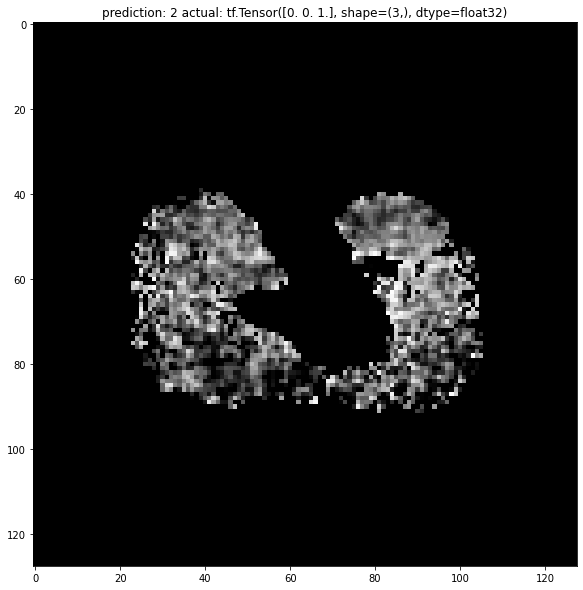

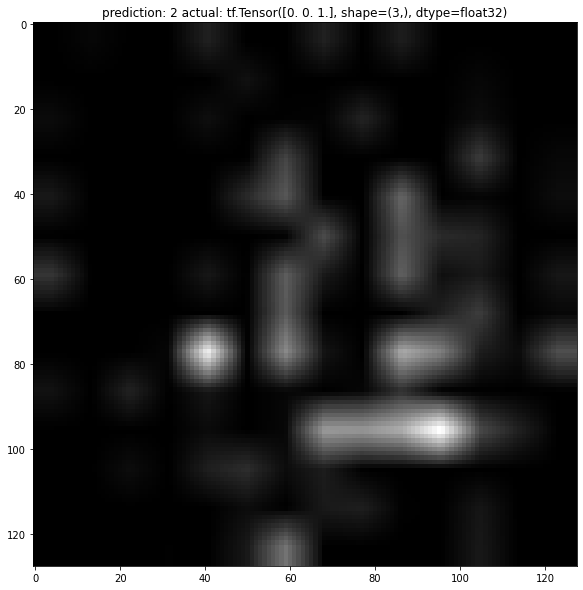

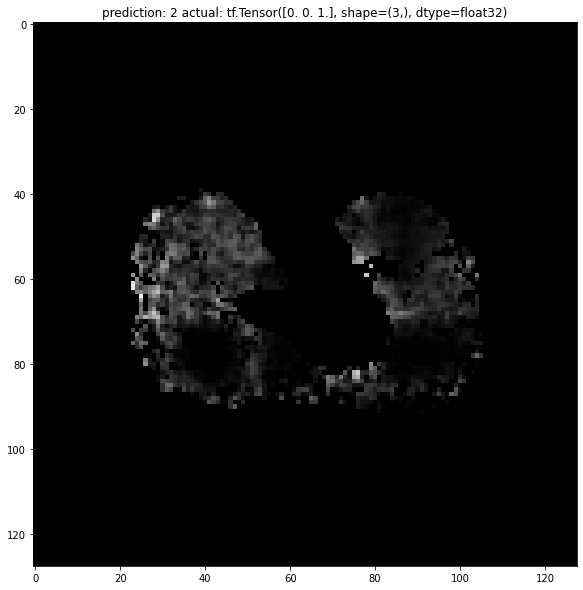

In [52]:

import imutils
def show_grad(model):



    model = model

    randi = random.randint(0,X_train.shape[0]-1)

    image = X_train[randi,:,:,:]
    label = y_train[randi]
    image = np.expand_dims(image,axis=0)
    orig = image.astype("float32")

    shape_ = image.shape
    preds = model.predict(image)

    
    i = np.argmax(preds[0])
    cam = GradCAM(model, i)

    heatmap = cam.compute_heatmap(image)
    #heatmap = cv2.resize(heatmap, (orig.shape[0], orig.shape[1]))

    output = cam.cut_heatmap(heatmap, orig, weight = 8)



    print(output.shape)
    # display the original image and resulting heatmap and output image
    # to our screen
    
    image = image[0,5,:,:,0]
    plt.figure(figsize=(20,10))
    plt.title("prediction: " + str(i) + " actual: " + str(label) )
    plt.imshow((image*255).astype('uint8'),'gray',vmin=0,vmax=255)
    
    
    
    
    heatmap = heatmap[0,5,:,:,0]
    heatmap = heatmap.numpy()
    plt.figure(figsize=(20,10))
    plt.title("prediction: " + str(i) + " actual: " + str(label) )
    plt.imshow((heatmap*255).astype('uint8'),'gray',vmin=0,vmax=255)
    
    output_save = output
    output = output[0,5,:,:,0]
    output = output.numpy()
    plt.figure(figsize=(20,10))
    plt.title("prediction: " + str(i) + " actual: " + str(label) )
    plt.imshow((output*255).astype('uint8'),'gray',vmin=0,vmax=255)
    print(np.max(orig))
    print("Image predictions: ", preds.round(3))
    print('real')
    print(label)
    print("Cut Image predictions: ",model.predict(tf.reshape(output_save,shape_)).round(3))
show_grad(model)

(1, 10, 128, 128, 1)
0.9746049
Image predictions:  [[1. 0. 0.]]
real
tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
Cut Image predictions:  [[1. 0. 0.]]


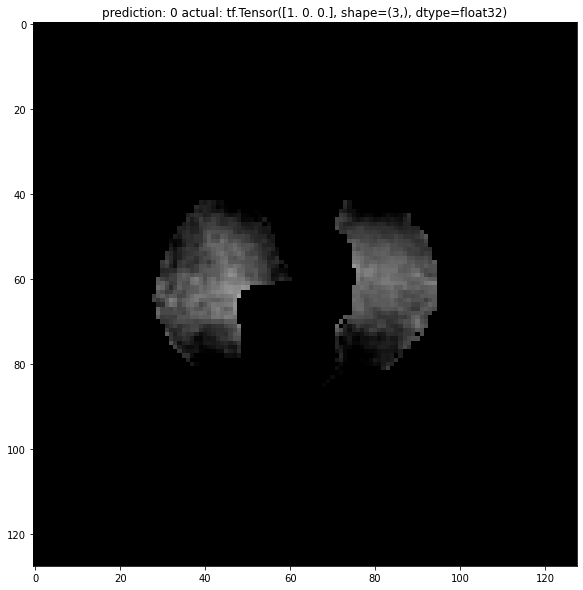

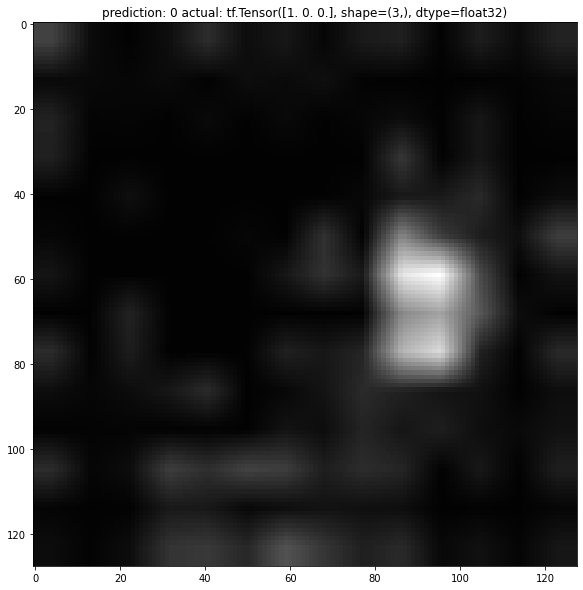

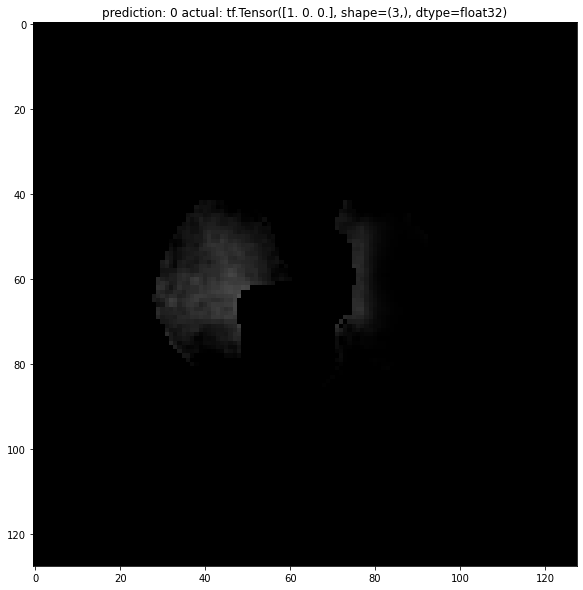

In [54]:
show_grad(model)

In [131]:
np.max(heatmap)

1.0

(1, 10, 128, 128, 1)
3.0451174
Image predictions:  [[0.001 0.    0.999]]
real
tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
Cut Image predictions:  [[1. 0. 0.]]


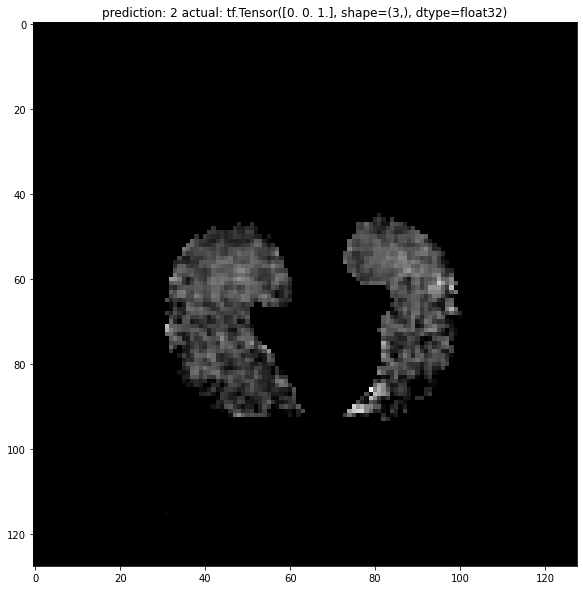

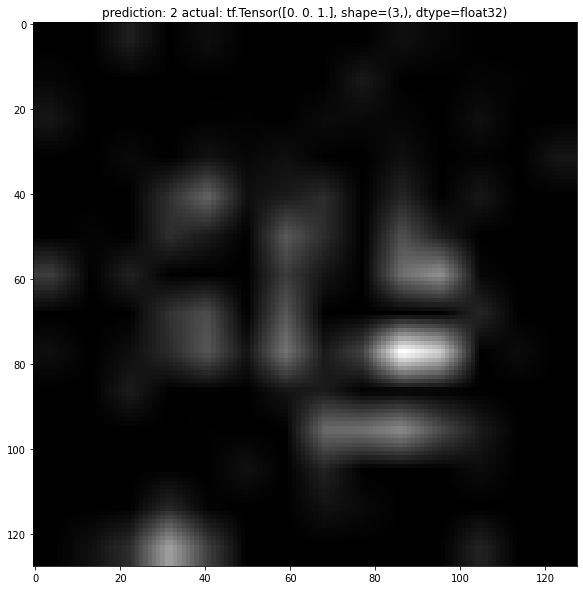

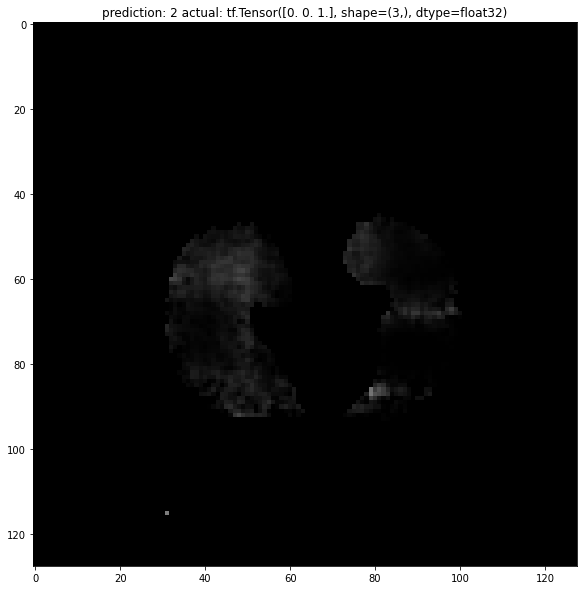

In [55]:
show_grad(model)

(1, 10, 128, 128, 1)
1.2239095
Image predictions:  [[0.253 0.747 0.   ]]
real
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
Cut Image predictions:  [[1. 0. 0.]]


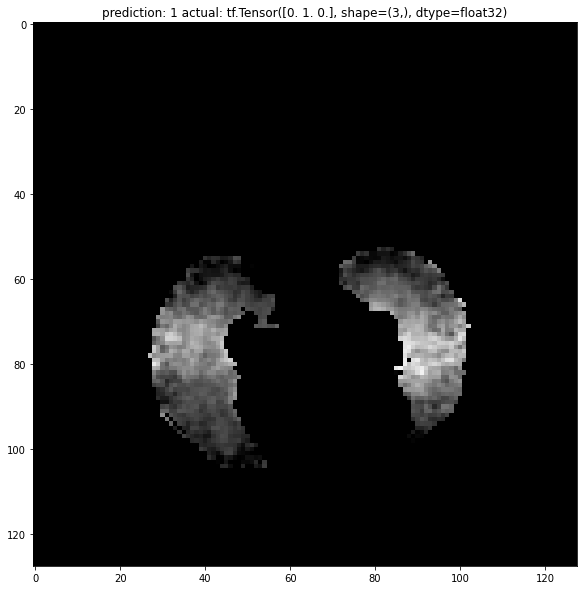

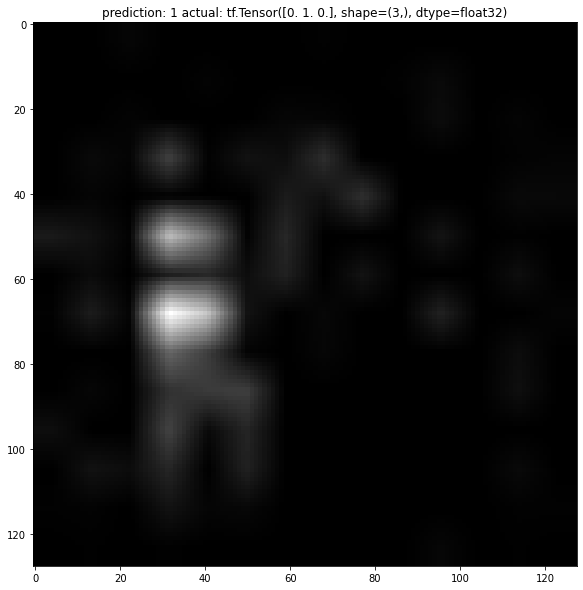

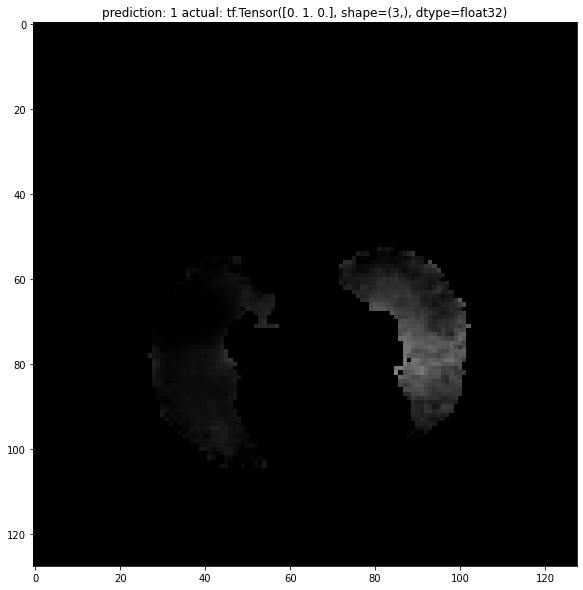

In [56]:
show_grad(model)

(1, 10, 128, 128, 1)
1.8988683
Image predictions:  [[0.034 0.    0.966]]
real
tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
Cut Image predictions:  [[0.999 0.    0.   ]]


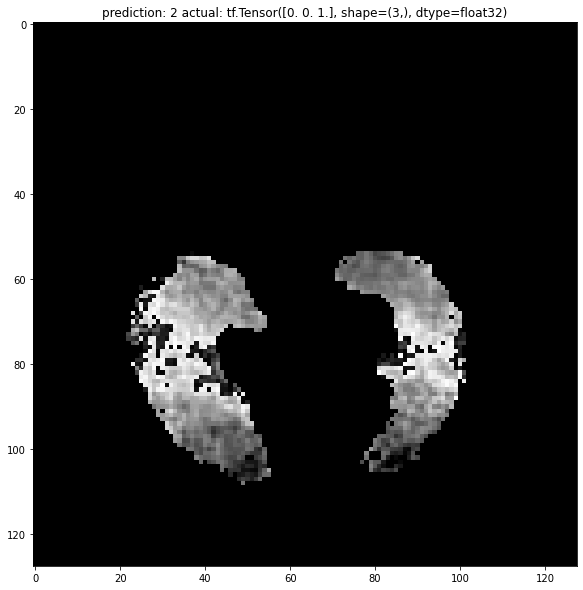

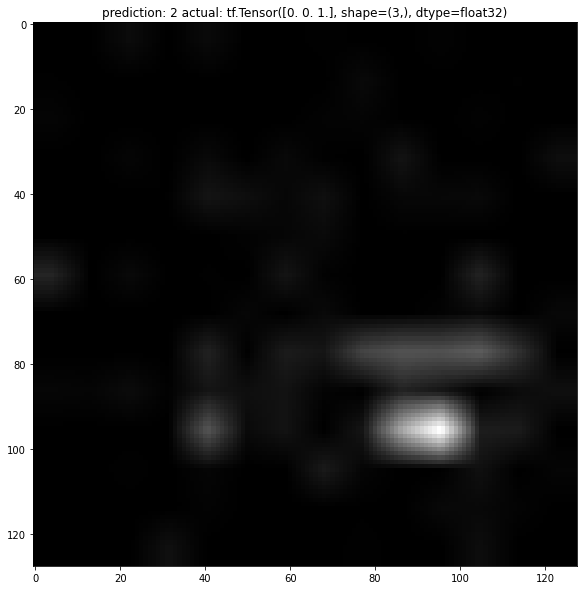

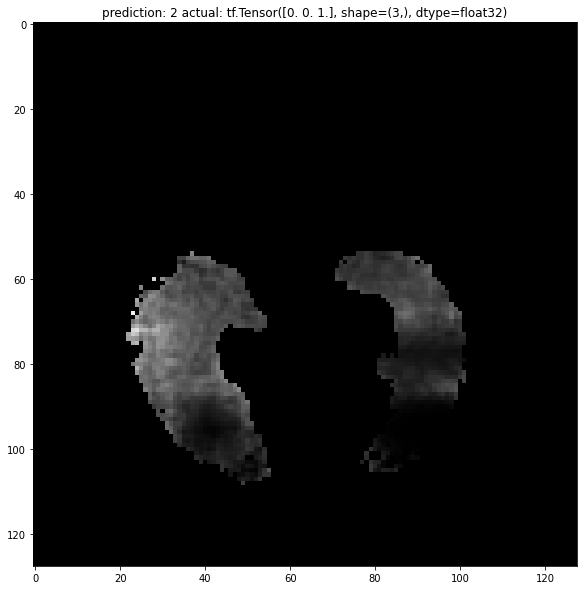

In [57]:
show_grad(model)

(1, 10, 128, 128, 1)
2.7487044
Image predictions:  [[0.999 0.001 0.   ]]
real
tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
Cut Image predictions:  [[1. 0. 0.]]


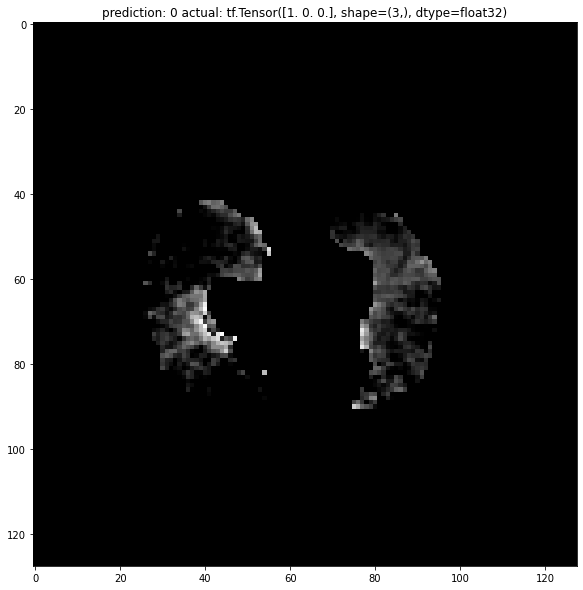

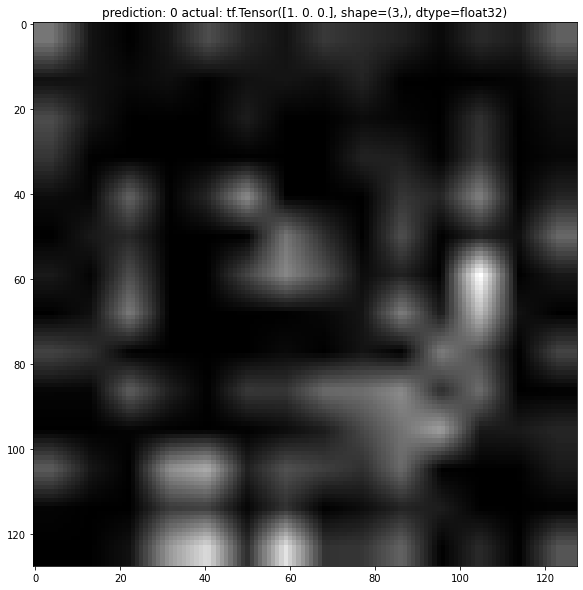

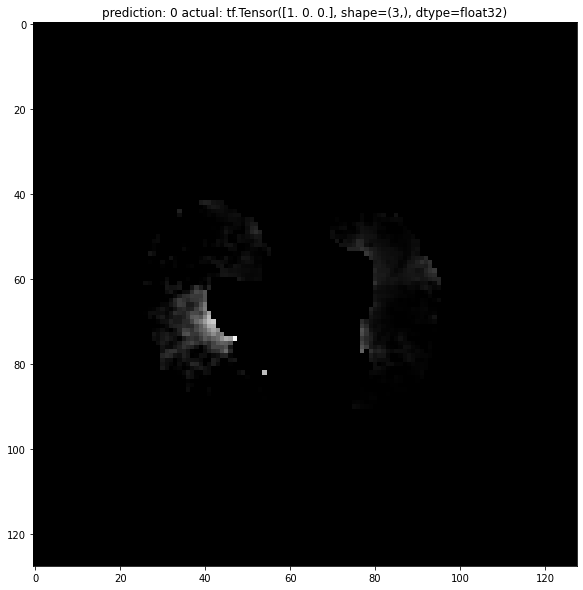

In [58]:
show_grad(model)

(1, 10, 128, 128, 1)
2.5606654
Image predictions:  [[0.991 0.    0.009]]
real
tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
Cut Image predictions:  [[1. 0. 0.]]


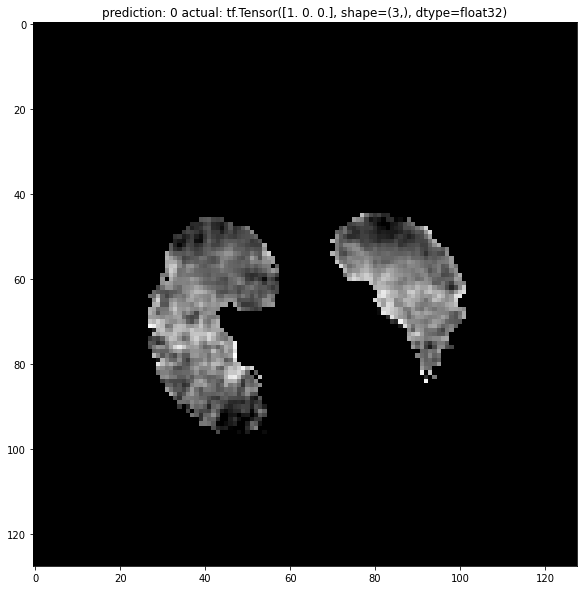

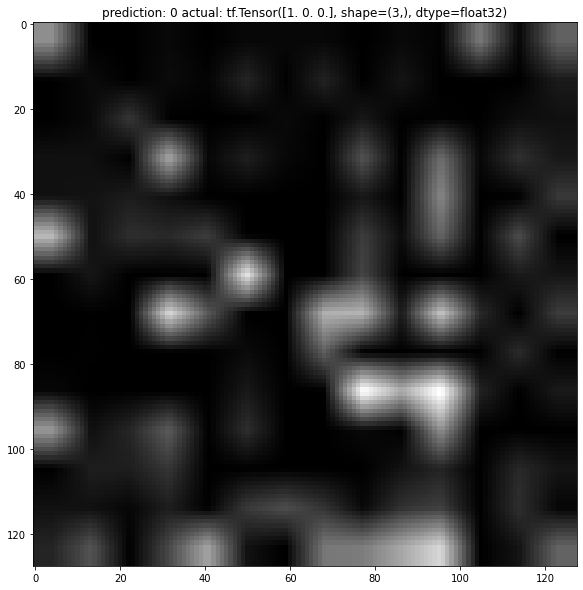

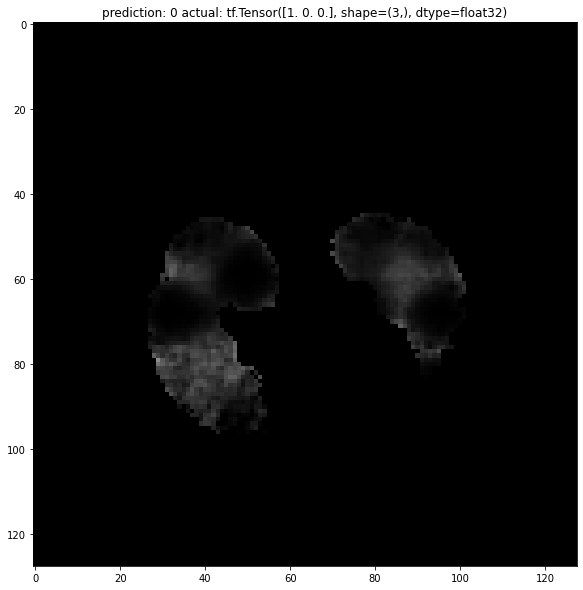

In [59]:
show_grad(model)

(1, 10, 128, 128, 1)
2.355764
Image predictions:  [[0. 0. 1.]]
real
tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
Cut Image predictions:  [[0.721 0.279 0.   ]]


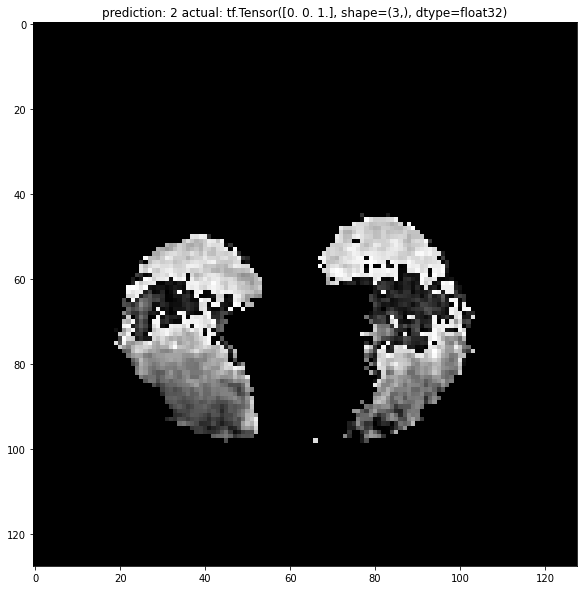

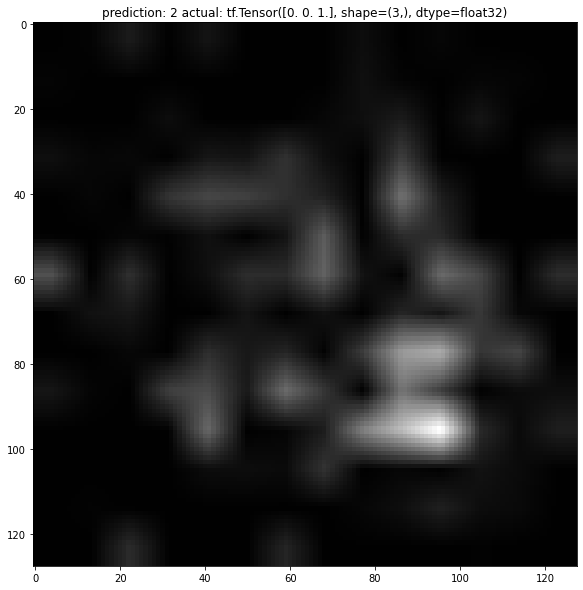

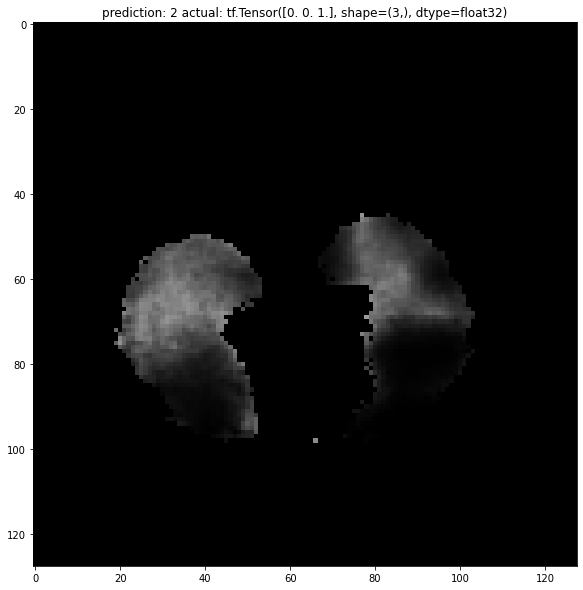

In [60]:
show_grad(model)

(1, 10, 128, 128, 1)
1.7511708
Image predictions:  [[0. 1. 0.]]
real
tf.Tensor([0. 1. 0.], shape=(3,), dtype=float32)
Cut Image predictions:  [[1. 0. 0.]]


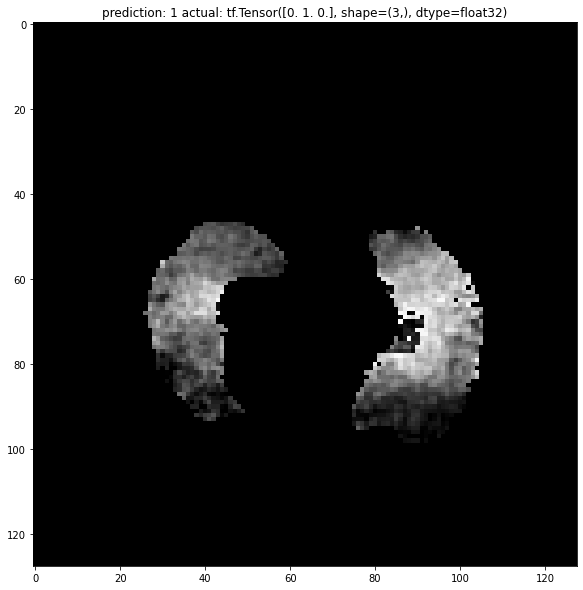

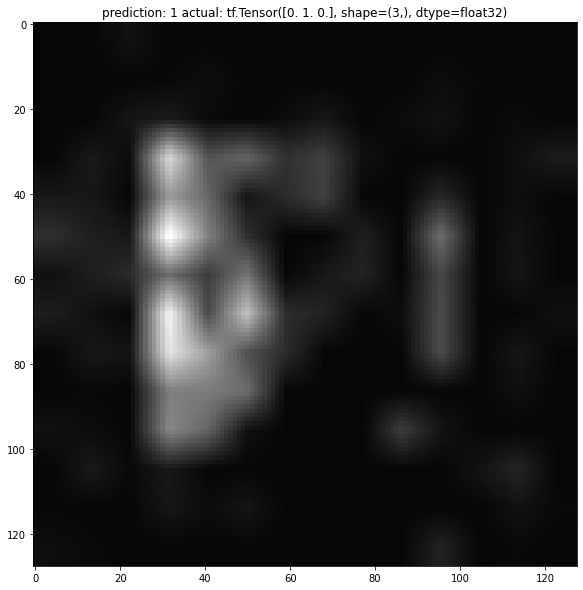

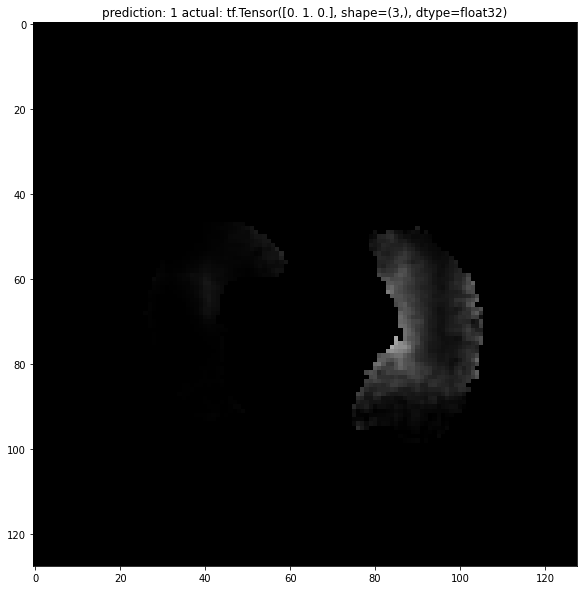

In [61]:
show_grad(model)

(1, 10, 128, 128, 1)
0.9746049
Image predictions:  [[1. 0. 0.]]
real
tf.Tensor([1. 0. 0.], shape=(3,), dtype=float32)
Cut Image predictions:  [[1. 0. 0.]]


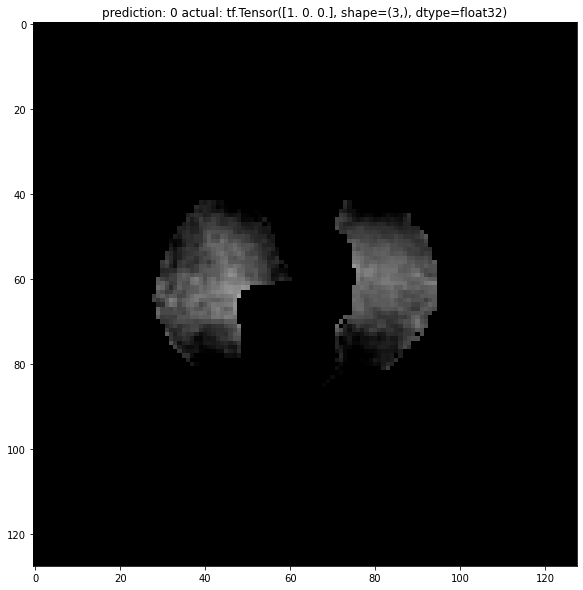

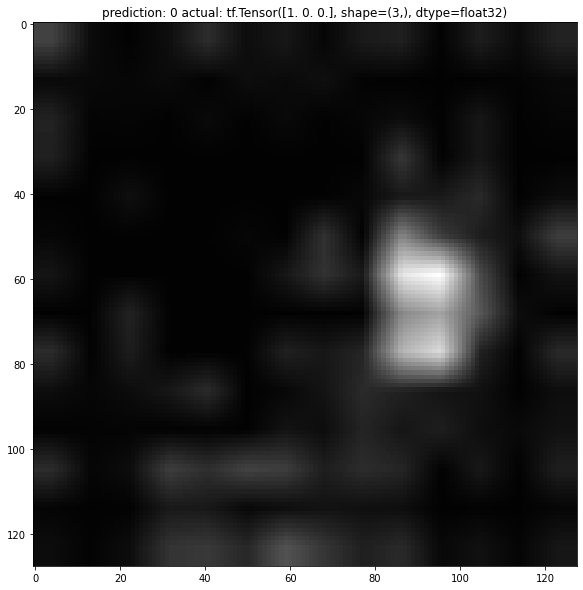

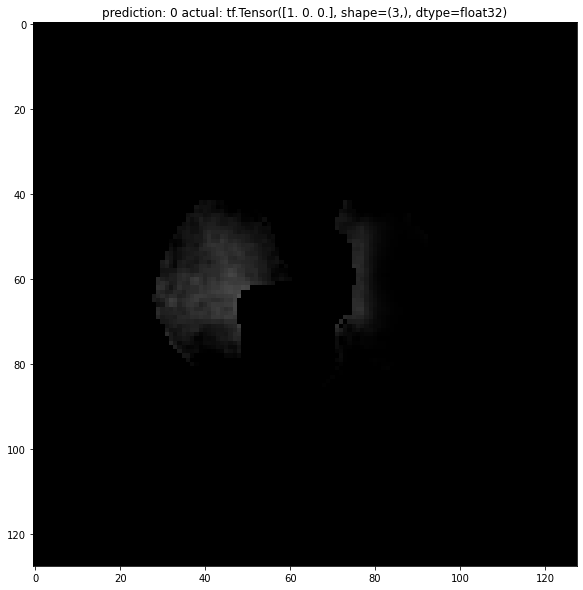

In [62]:
show_grad(model)

(1, 10, 128, 128, 1)
2.1673281
Image predictions:  [[0.001 0.    0.999]]
real
tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
Cut Image predictions:  [[0.975 0.025 0.   ]]


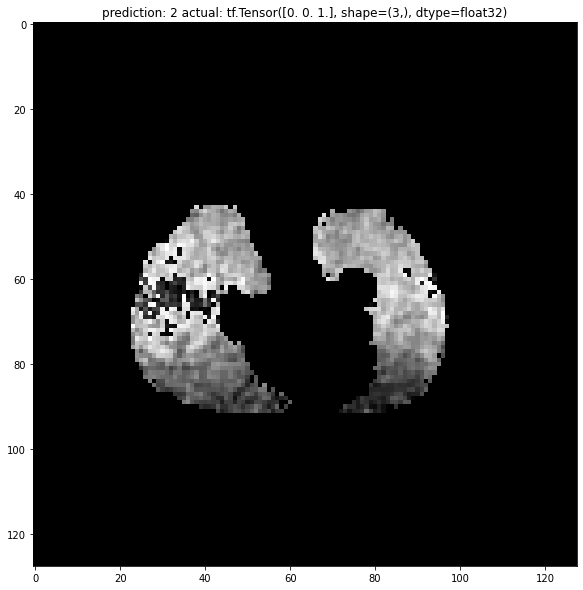

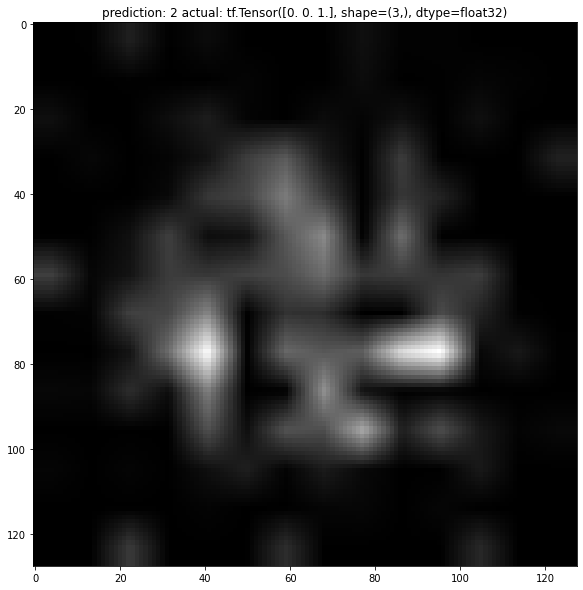

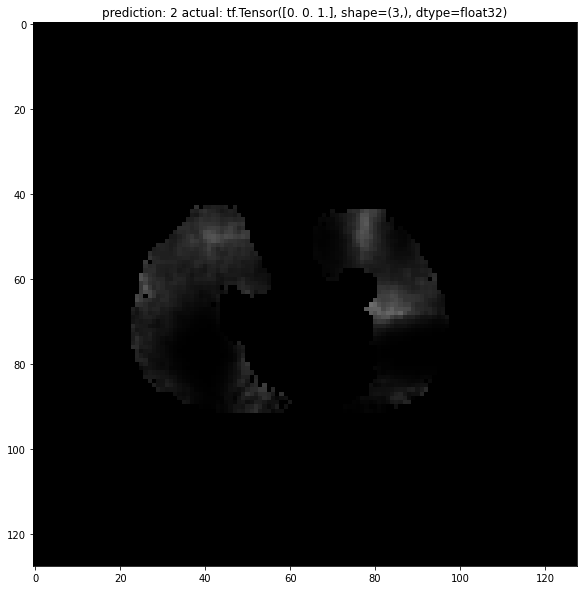

In [63]:
show_grad(model)